# Tests

This notebook
- installs the repo 
- runs pytests
- load the page config
- does an EVP sweep for stable and unstable baselines and plots growth vs k
- shows how to read written artifcacts (manifest, checpoints)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %% diffinst bootstrap (install only if needed)
import os, sys, subprocess, importlib.util
from pathlib import Path

# --- find repo root (pyproject.toml) ---
ROOT = Path.cwd().resolve()
while not (ROOT / "pyproject.toml").exists():
    if ROOT == ROOT.parent:
        raise RuntimeError("Could not find repo root (pyproject.toml not found).")
    ROOT = ROOT.parent

SRC = ROOT / "src"
PKG = SRC / "diffinst"

if not PKG.exists():
    raise RuntimeError(f"Expected package at {PKG}")

os.chdir(ROOT)

print("Project root:", ROOT)
print("Python:", sys.executable)

# --- make imports work in THIS notebook kernel right now ---
if str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))

# --- make imports work for NEW python processes (python -m scripts....) ---
os.environ["PYTHONPATH"] = str(SRC) + (os.pathsep + os.environ["PYTHONPATH"] if os.environ.get("PYTHONPATH") else "")

# --- check if diffinst already imports from THIS repo ---
spec = importlib.util.find_spec("diffinst")
need_install = True

if spec and spec.origin:
    origin = Path(spec.origin).resolve()
    print("Current diffinst origin:", origin)
    # src layout: origin should be ROOT/src/diffinst/__init__.py
    if origin == (PKG / "__init__.py").resolve():
        need_install = False

if need_install:
    print("Installing diffinst (editable) from this repo...")
    subprocess.run([sys.executable, "-m", "pip", "install", "-e", "."], check=True)
else:
    print("Editable install not needed (diffinst already imports from this repo).")

# --- verify ---
import diffinst
print("diffinst import OK; origin =", diffinst.__file__)

Project root: /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst
Python: /opt/anaconda3/envs/dedalus3/bin/python
Current diffinst origin: /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/src/diffinst/__init__.py
Editable install not needed (diffinst already imports from this repo).
diffinst import OK; origin = /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/src/diffinst/__init__.py


In [3]:
# now imports are safe and point to this repo
from diffinst import Config
from diffinst.linear_ops import evp_solve_at_k
import numpy as np
import matplotlib.pyplot as plt

# handy paths
EXP_STABLE   = ROOT / "experiments" / "baseline.yaml"
EXP_UNSTABLE = ROOT / "experiments" / "unstable_baseline.yaml"
EXP_LARGEDIFF = ROOT / "experiments" / "diffinst_largeDiff_limit.yaml"
DEFAULTS     = ROOT / "defaults.yaml"
RUNS         = ROOT / "runs"; RUNS.mkdir(exist_ok=True)

print("project root:", ROOT)

project root: /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst


### Current tests
- test_config.py
- test_evp.py
- test_io.py

In [4]:
import pytest
res = pytest.main(["-q"])
print("pytest exit code:", res)

....                                                                     [100%]
4 passed in 1.19s
pytest exit code: 0


## EVP sweep with unstable baseline

Compute dominant eigenvalue for each k and plot growth (= Re(n))

In [5]:
cfg = Config.from_yaml(EXP_UNSTABLE, DEFAULTS)
kmin, kmax, nk = 10, 1e4, 120
ks = np.logspace(np.log10(kmin), np.log10(kmax), nk)

growth = np.empty(nk)
freq   = np.empty(nk)
for i, k in enumerate(ks):
    w, _ = evp_solve_at_k(cfg, float(k))
    growth[i] = w[0].real
    freq[i]   = w[0].imag

imax = int(np.argmax(growth))
print(f"max growth at k ≈ {ks[imax]:.3g}  ->  γ ≈ {growth[imax]:.4g},  ω ≈ {freq[imax]:.4g}")

max growth at k ≈ 411  ->  γ ≈ 0.4155,  ω ≈ 1.08e-16


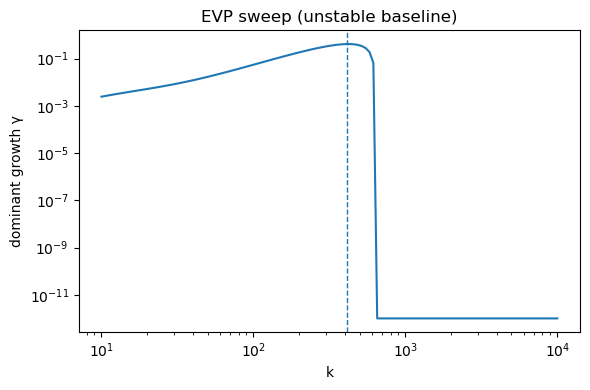

In [6]:
plt.figure(figsize=(6,4))
plt.loglog(ks, np.maximum(growth, 1e-12))  # show tiny values as floor
plt.axvline(ks[imax], ls="--", lw=1)
plt.xlabel("k")
plt.ylabel("dominant growth γ")
plt.title("EVP sweep (unstable baseline)")
#plt.title(r"EVP sweep $\delta = 10^5$")
plt.tight_layout()

## Eigenvector

S = sig/sig_0

In [7]:
from numpy import angle
w, V = evp_solve_at_k(cfg, float(ks[imax]))
dom_v = V[:,0]  # [S, vx, vy, uy]
labels = ["S", "vx", "vy", "uy"]
amps = np.abs(dom_v)
phs  = angle(dom_v)

for lab, a, p in zip(labels, amps, phs):
    print(f"{lab:>2s}: |.|={a:.3e},  phase={p:.3f} rad")

 S: |.|=1.000e+00,  phase=0.000 rad
vx: |.|=1.012e-03,  phase=-1.571 rad
vy: |.|=7.566e-04,  phase=-1.571 rad
uy: |.|=4.226e-05,  phase=-1.571 rad


## Read a manifest / checkpoint from a dry run

Run
`python -m scripts.run_linear --config experiments/baseline.yaml --outdir runs/linear --dry-run`
from notebook via bang command CLI. 

In [8]:
!python -m scripts.run_linear --config experiments/baseline.yaml --outdir runs/linear --dry-run

[dry] wrote one checkpoint; backend = native | Lx = 0.2


load manifests and checkpoints of dryrun

In [9]:
import json

run_dir = ROOT / "runs" / "linear"
man = run_dir / "run.json"
chk0 = run_dir / "checkpoints" / "chk_000000.npz"

if man.exists() and chk0.exists():
    with man.open() as f:
        meta = json.load(f)
    arrs = np.load(chk0)
    print("manifest keys:", list(meta.keys()))
    print("checkpoint arrays:", arrs.files)
    for key in arrs.files:
        print(f"  {key}: shape={arrs[key].shape}, dtype={arrs[key].dtype}")
else:
    print("no dry-run outputs found; run the dry script once to populate.")

manifest keys: ['kind', 'config', 'Lx', 'backend']
checkpoint arrays: ['t', 'x']
  t: shape=(), dtype=float64
  x: shape=(128,), dtype=float64


In [10]:
!python -m scripts.run_evp --config experiments/unstable_baseline.yaml --kmin 10 --kmax 1e3 --nk 120 --out runs/evp_unstable --plot

[evp] max growth at k=426.8: gamma=0.4163, omega=-2.829e-16
[evp] saved plot -> runs/evp_unstable/preview_growth.png


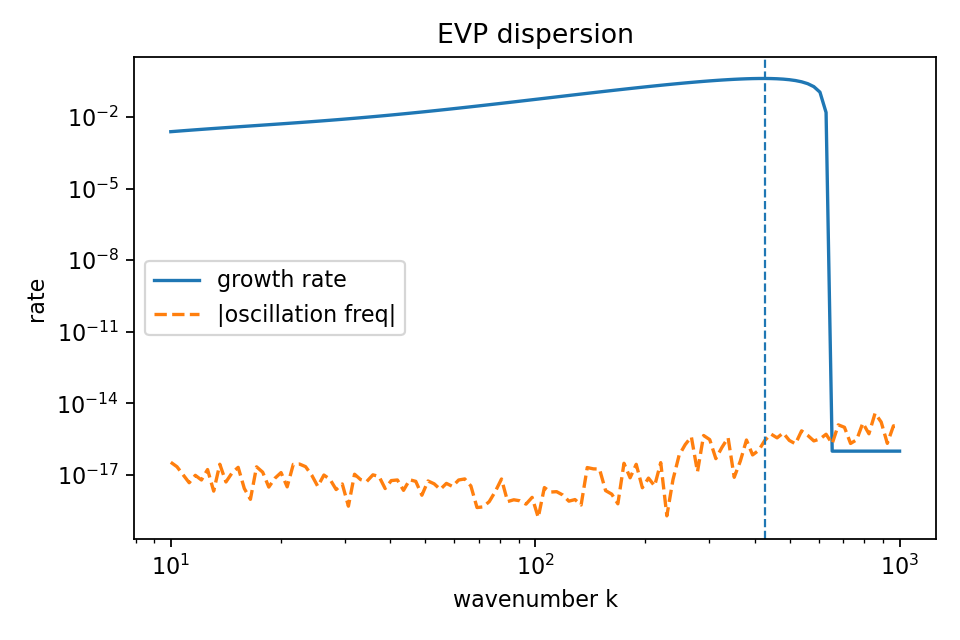

In [11]:
from IPython.display import Image, display
display(Image(filename="runs/evp_unstable/preview_growth.png"))